<h1>The Goal</h1>

This notebook contains an attempt made by Callum Rai, Hollie Parry, and Joshua Heckroodt, three students versus climate change, to provide relief from natural disasters to communities across the world. In particular, given the incline in average global temperature we've seen over the course of the last several years (roughly 0.18 degrees Celcius every decade since 1981), regions the likes of Australia and California (in the United States) have become particularly susceptible to wildfire instances, instances the likes of which the model described by this notebook will attempt to predict to super-human degress of accuracy.

<h1>Dataset Specification</h1>

Of course, the dataset we are given contains a total of nearly 1.5 million different items of climate data. This dataset, however, is unfortunately subject to a notable class imbalance, and hence our model will be trained on a class-balanced selection of roughly 300,000 different items of climate data from the aforementioned dataset, with the hopes of identifying an underlying pattern said model can then use to make accurate predictions in the future. Relevant attributes of each item of data includes
<ol>
    <li><code>lat</code>, the latitude in question.</li>
    <li><code>lon</code>, the longitude in question.</li>
    <li><code>year</code>, <code>month</code>, <code>day</code>, the three items of data used for specifying the date at the time of recording.</li>
    <li><code>precipitationAverage</code>, the average daily precipitation at the time of recording.</li>
    <li><code>temperatureAverageMax</code>, <code>temperatureAverageMin</code>, <code>temperatureMean</code>, <code>temperatureRecordMax</code>, <code>temperatureRecordMin</code>, the five items of data used to describe, as wholly as possible, the temperature at the time of recording.</li>
</ol>
It should be noted also that our data is the consequence of recordings made in the destinations across the United States, exclusively, including some states notoriously subject to some of the world's most rampant wildfires, the likes of California, and the Carolinas. Below we introduce a series of cells used to visualize the data it its entirety (after importing a series of relevant modules and/or methods).

In [97]:
import seaborn as sb
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers

%matplotlib inline

In [98]:
#LOAD CELL 1
import pandas as pd

df = pd.read_csv(relevant_path)

Let us start by investigating some simple properties of our dataset, like its headers, shape, the frequency of some relevant output features, and a description of our dataset.

In [99]:
df.head()

,Unnamed: 0,Unnamed: 0.1,lat,lon,year,month,day,date,fire_7,fire_30,precipitationAverage,temperatureAverageMax,temperatureAverageMin,temperatureMean,temperatureRecordMax,temperatureRecordMin
0,0,"((34.0, -81.0), datetime.date(2016, 3, 27))",34.0,-81.0,2016.0,3.0,27.0,2016-03-27,0.0,1.0,3.30,23.0,9.0,17.0,31,-6.0
1,1,"((41.0, -97.0), datetime.date(2016, 2, 22))",41.0,-97.0,2016.0,2.0,22.0,2016-02-22,0.0,0.0,0.51,5.0,-7.0,-1.0,24,-22.0
2,2,"((31.0, -95.0), datetime.date(2017, 10, 31))",31.0,-95.0,2017.0,10.0,31.0,2017-10-31,1.0,1.0,3.56,25.0,10.0,17.0,32,-3.0
3,3,"((31.0, -92.0), datetime.date(2019, 8, 10))",31.0,-92.0,2019.0,8.0,10.0,2019-08-10,0.0,1.0,3.05,34.0,22.0,28.0,38,15.0
4,4,"((31.0, -96.0), datetime.date(2017, 5, 23))",31.0,-96.0,2017.0,5.0,23.0,2017-05-23,1.0,0.0,3.56,31.0,18.0,24.0,36,11.0


In [100]:
print("Your dataset has shape "+str(df.shape))

Your dataset has shape (303901, 16)


Percentage of wildfire intances (active 7 days after recording), given the above data: 41.201904567605894%, as seen below.


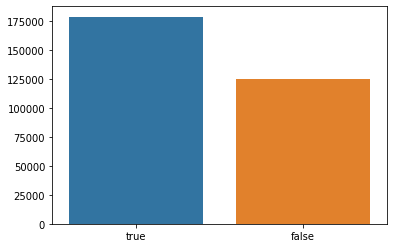

In [101]:
(y,y_true)=(df['fire_7'].value_counts(),df["fire_7"][df["fire_7"]==True])
data={'fire_7':['true','false'],
     'frequency':[y[0],y[1]]}

sb.barplot(x='fire_7',y='frequency',data=data)

print("Percentage of wildfire intances (active 7 days after recording), given the above data: "+str(100*(y_true.shape[0]/df.shape[0]))+"%, as seen below.")


From the above plot, it can be seen how our class imbalance has been significantly reduced, as required. From here, let us turn our attention to trends within the data. In particular, we require something of an identifiable pattern present in our data for us to have faith that our (eventual) model will be able to produce meaningful predictions, given the aforementioned data. We will investigate the correlation between <code>fire_7</code> and
<ol>
    <li><code>month</code></li>
    <li><code>precipitationAverage</code></li>
    <li><code>temperatureAverageMax</code></li>
    <li><code>temperatureMean</code></li>
</ol>
in said order.

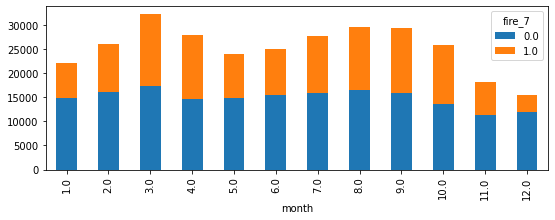

In [102]:
df.groupby(["month","fire_7"]).size().unstack().plot(kind="bar",stacked=True,figsize=(9,3))

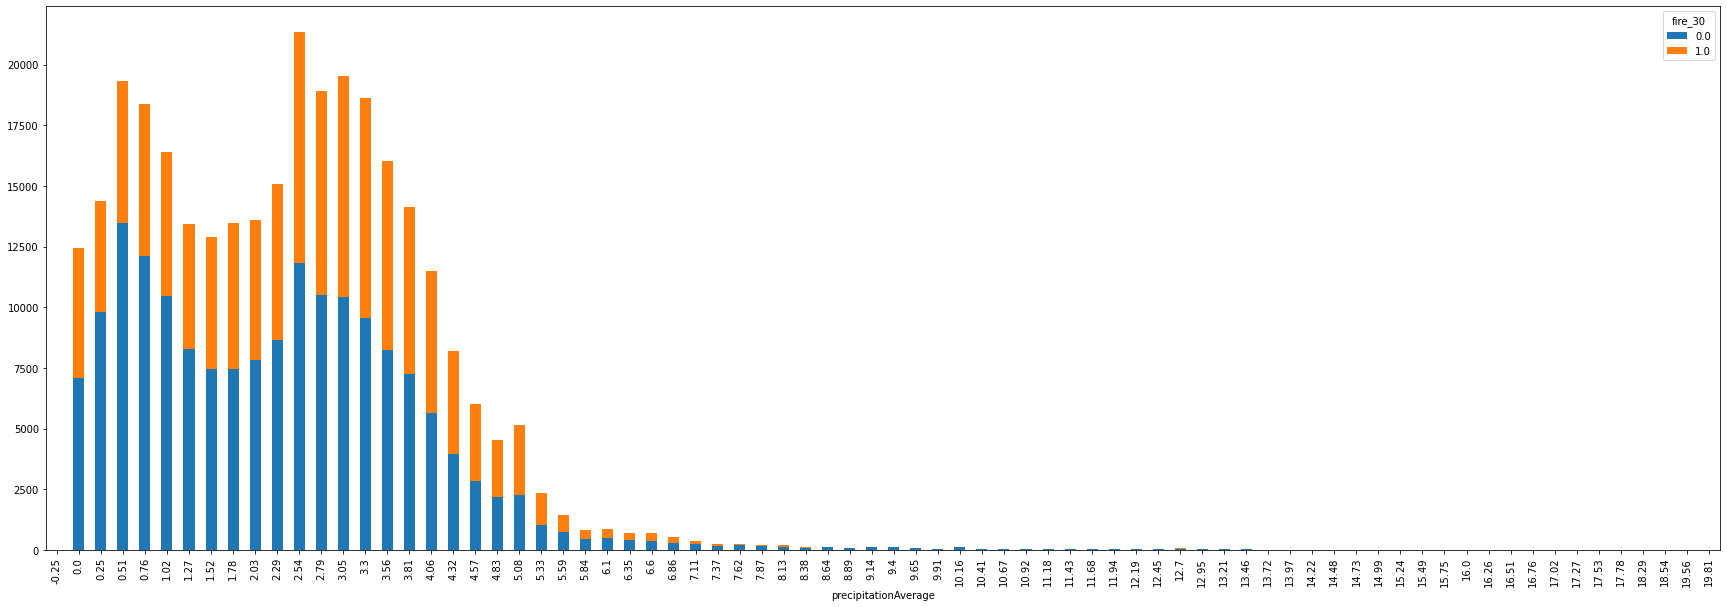

In [103]:
df.groupby(["precipitationAverage","fire_30"]).size().unstack().plot(kind="bar",stacked=True,figsize=(30,10))

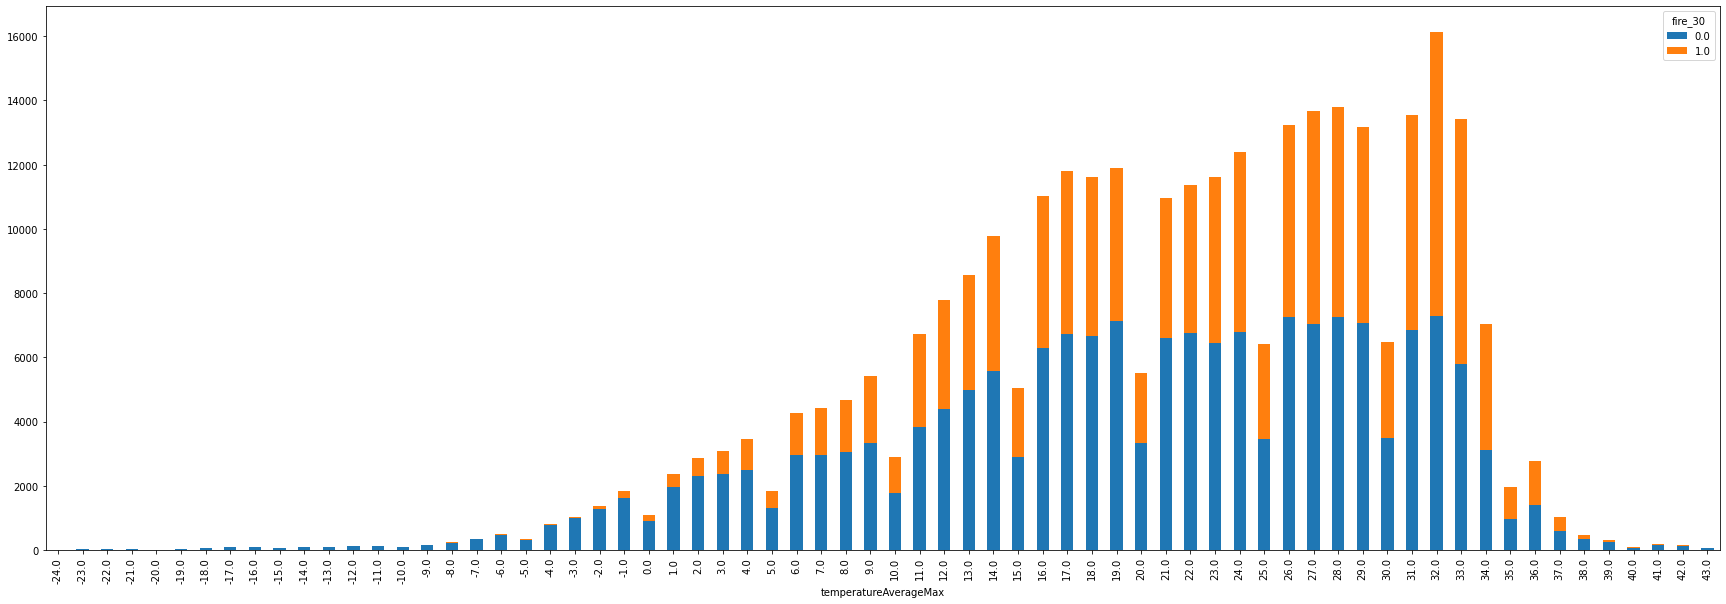

In [104]:
df.groupby(["temperatureAverageMax","fire_30"]).size().unstack().plot(kind="bar",stacked=True,figsize=(30,10))

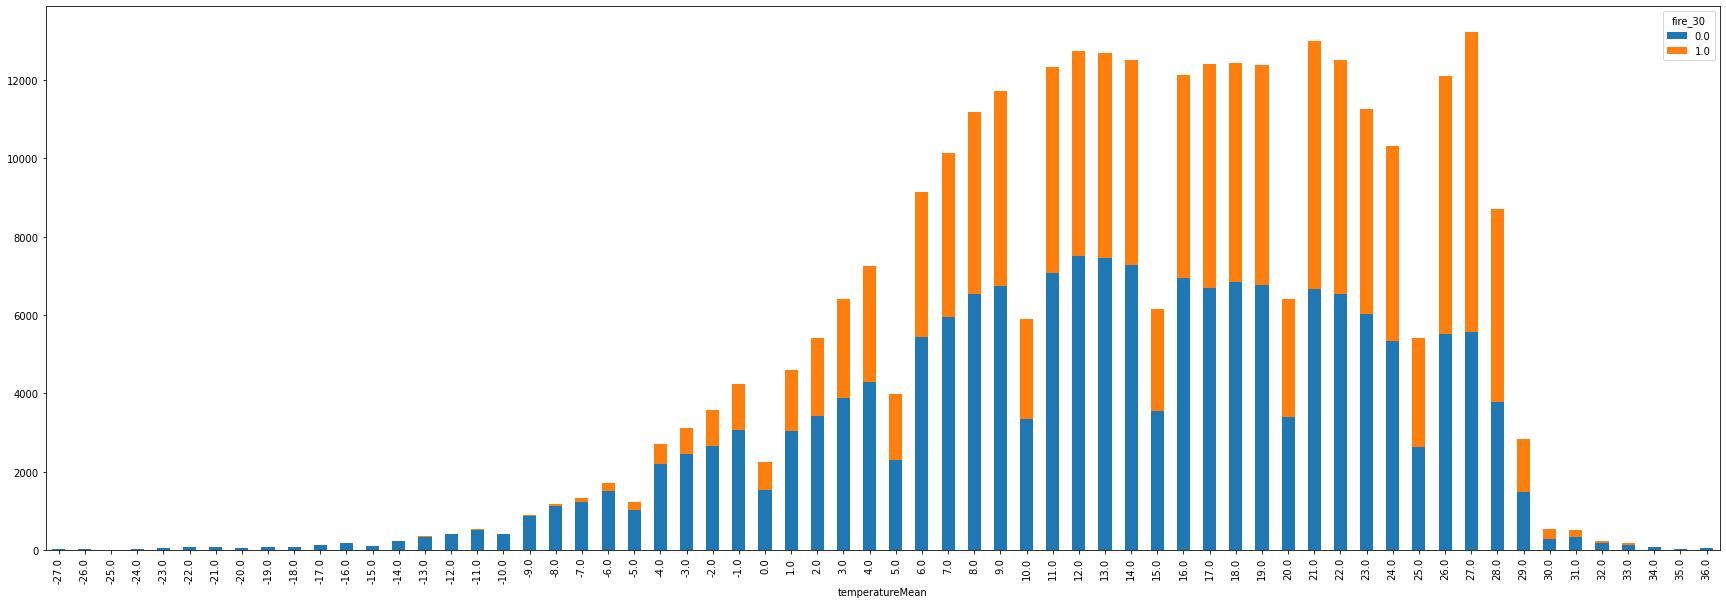

In [105]:
df.groupby(["temperatureMean","fire_30"]).size().unstack().plot(kind="bar",stacked=True,figsize=(30,10))

There are a couple of key observations we should make from the plots presented above. Firstly, note that there doesn't appear to be too strong of a correlation between the time of year and the likelihood of a wildfire occuring (and being active a week after recording the relevant data). It should be noted that this isn't necessarily a consequence of the seasonal difference between the northern and southern hemispheres, since our data is accrued from locations in the northern hemipshere, exclusively.

That being said, though, there does appear to be a striking correlation between the frequency of wildfires (and, again, being active a week after recording), and all of the average daily precipitation at the time of recording, the average daily maximum temperature at the time of recording, and the average daily temperature at the time of recording. This bodes well for our ability to model the above data. For this reason, we advance now to our preprocessing of the data.

<h1>Preprocessing the Data</h1>
<h2>Combining Features</h2>

The first step we will execute in preprocessing our data involves combining particular features, so as to introduce a series of more intricate features our model may utilize to produce wildfire predictions. In particular, we perform the following combinations.
<ul>
    <li>Encode <code>month</code> in accordance with the one-hot encoding format. That is, as opposed to encoding the <code>month</code> as a single integer value between 1 and 12, we will now encode it using a 12-dimensional vector, whose elements are all 0, with the exception of a single 1, whose index corresponds to the value <code>month</code> assumed, prior to our conversion to one-hot encoding.</li>
    <li>Element-wise multiplication of each <code>month</code> encoding the corresponding <code>lat</code> attribute (a simple scalar quantity) and the corresponding <code>lon</code> attribute (again, a simple scalar quantity). This type of combination combines locational and seasonal data, to ensure that these two attributes do not interact <b>independently</b> with the model's prediction capacity, thereby making it easier for the model to identify particular patterns (as we'd like for it to do).</li>
    <li>We repeat the above means of combining features, this time utilizing <code>lat</code> and <code>lon</code>, <code>lat</code> and <code>precipitationAverage</code>, <code>lon</code> and <code>precipitationAverage</code>, <code>lat</code> and <code>temperatureMean</code>, <code>lon</code> and <code>temperatureMean</code>, omitting the process of converting to one-hot encoding, where relevant.
</ul>
The process described above is rather much to include in this notebook, and as a consequence will be included as a separate block of code. We have instead the following cell that simply loads in the aforementioned data using the <code>Pandas</code> library.

In [106]:
#LOAD CELL 2
df_train = pd.read_csv(relevant_path)

From here, we advance to our definitions of the response and feature matrices.

<h2>Defining the Response and Feature Vectors</h2>

We start by initializing our response vectors, <code>Y</code>, as well as our feature vectors, <code>X</code>, (which we will do using none other than the <code>NumPy</code> library), in this order. We have the following.

In [107]:
Y=np.array(df_train[["fire_7","fire_30"]],dtype=np.uint8)
print("Our response matrix is of shape "+str(Y.shape))

Our response matrix is of shape (303901, 2)


Note, from the above, that each response vector is comprised of two elements: an element corresponding to the occurence of a wildfire active 7 days after recording the relevant data, and another element corresponding to the occurence of a wildfire active 30 days after recording the relevant data. We will see how this form of our response vector impacts our loss function in due course.

In [108]:
X=np.array(df_train[["lat","lon",
                     "year","day",
                     "precipitationAverage",
                     "temperatureAverageMax","temperatureAverageMin",
                     "temperatureMean",
                     "temperatureRecordMax","temperatureRecordMin",
                     "month_1.0",
                     "month_2.0",
                     "month_3.0",
                     "month_4.0",
                     "month_5.0",
                     "month_6.0",
                     "month_7.0",
                     "month_8.0",
                     "month_9.0",
                     "month_10.0",
                     "month_11.0",
                     "month_12.0",
                     "lat_lon",
                     "lat_precipitationAverage","lat_temperatureMean",
                     "lon_precipitationAverage","lon_temperatureMean",
                     "month_1.0_lat","month_1.0_lon",
                     "month_2.0_lat","month_2.0_lon",
                     "month_3.0_lat","month_3.0_lon",
                     "month_4.0_lat","month_4.0_lon",
                     "month_5.0_lat","month_5.0_lon",
                     "month_6.0_lat","month_6.0_lon",
                     "month_7.0_lat","month_7.0_lon",
                     "month_8.0_lat","month_8.0_lon",
                     "month_9.0_lat","month_9.0_lon",
                     "month_10.0_lat","month_10.0_lon",
                     "month_11.0_lat","month_11.0_lon",
                     "month_12.0_lat","month_12.0_lon"]],dtype=np.float64)
print("Our feature matrix is of shape "+str(X.shape))

Our feature matrix is of shape (303901, 51)


<h2>Splitting the Data into Train and Test (Validation) Sets</h2>

We utilize the <code>sklearn</code> library for this purpose. In particular, we utilize the <code>train_test_split</code> method. Note that, since we have roughly 300,000 items of data in our dataset, if we utilize as little as $5\%$ of our dataset as a test set, we'd still end up with a test set of roughly 15,000 items of data. We hence abide by this split to arrive at the following call.

In [109]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.05,random_state=42)
print("Our training response matrix is of shape "+str(Y_train.shape))
print("Our training feature matrix is of shape "+str(X_train.shape))
print("Our test response matrix is of shape "+str(Y_test.shape))
print("Our test feature matrix is of shape "+str(X_test.shape))

Our training response matrix is of shape (288705, 2)
Our training feature matrix is of shape (288705, 51)
Our test response matrix is of shape (15196, 2)
Our test feature matrix is of shape (15196, 51)


Note that, in particular, our test set is comprised of 15,196 elements of our dataset.

<h1>Defining the Model</h1>
The following list specifies the model in its current state. Of course, deep learning is a highly iterative process, and as a consequence our model may enjoy several renditions in the future that result in even greater performance than enabled by the current hyperparameters.
<ul>
    <li>
<h2>Architecture and Activation Functions</h2>
        
Firstly, we note that our model will assume the form of a fully connected deep artificial neural network. Given the shape of our feature matrix, we require 21 nodes in our input layer, in addition to 6 hidden layers, with hidden nodes 64, 32, 16, 16, 8, and 4, respectively (we use this many hidden layers to ensure that our model has the infrastructure necessary to deal with the potential complexity of the data at hand). Our output layer is, of course, comprised of 2 nodes.

Our model assumes that the problem at hand may be regarded as a <b>binary classification</b> problem, and hence we utilize the sigmoid activation function in the final layer of our network. For each of the other layers, though, we will utilize the ReLU activation function, given its resistance to vanishing gradients.
    </li>
    <li>
<h2>Loss Function, Metrics, and other Hyperparameters</h2>

We will utilize the binary cross-entropy loss function (generalized to response vectors with several components, as opposed to scalar quantities). We will monitor the value the aforementioned loss function assumes (as well as the accuracy of our model's predictions) thoughout the duration of the training procedure. We will also make use of the following.
        <ul>
            <li>The adaptive moment estimation ("<i>Adam</i>") optimizer, with standard $\beta_1$ and $\beta_2$ values (0.9 and 0.999, respectively), and a particular learning rate schedule (which we will specify shortly).</li>
            <li><i>He</i> weight initialization (since <code>keras</code> requires the following distinction, we note that we will utilize <i>He</i> normal intialization, in particular, as opposed to <i>He</i> uniform intialization, which we would utilize, instead, in the even of a shift in paradigm to a regression-type problem).</li>
            <li>Normalization of the feature matrix.</li>
            <li>We may also utilize dropout regularization (with a dropout likelihood of $20\%$, or <code>0.2</code>) between the first and second fully connected layers, as well as between the second and third fully connected layers (as these are the layers with the greatest number of nodes), both to prevent overfitting, and reduce the likelihood of dead ReLU units.</li>
            <li>Mini-batch gradient descent with a batch size of 256, in addition to a total of 50 epochs at each of the following learning rates: <code>1e-4</code>, <code>1e-5</code>, and an additional 100 epochs at a learning rate of <code>1e-6</code> (this is our learning rate schedule).</li>
        </ul>
From here, we are ready to introduce the code responsible for the training discussed above.

In [112]:
def adjust_lr(epoch,lr):
    '''
    Description: this method is necessary for our implementation of LearningRateScheduler
    to work.
    
    Inputs:
    - epoch: the number corresponding to the current epoch
    - lr: the current learning rate (we won't actually use this argument, but it is
          syntaxically necessary)
    
    Outputs:
    - lr_new: the new learning rate (which may be equal to lr)
    '''
    if epoch<50:
        return 1e-4
    elif 50<=epoch<100:
        return 1e-4
    elif 100<=epoch:
        return 1e-5

schedule_lr=LearningRateScheduler(adjust_lr)
    
#instantiate the model    
wildfire_model=Sequential()

#specify the feature vector shape
wildfire_model.add(Input((51,)))

#add normalization layer
norm_layer=Normalization()
norm_layer.adapt(X_train)
wildfire_model.add(norm_layer)

#add our hidden layers
wildfire_model.add(Dense(64,activation="relu",kernel_initializer="he_normal"))
wildfire_model.add(Dense(32,activation="relu",kernel_initializer="he_normal"))
wildfire_model.add(Dense(16,activation="relu",kernel_initializer="he_normal"))
wildfire_model.add(Dense(16,activation="relu",kernel_initializer="he_normal"))
wildfire_model.add(Dense(8,activation="relu",kernel_initializer="he_normal"))
wildfire_model.add(Dense(4,activation="relu",kernel_initializer="he_normal"))

#add our output layer
wildfire_model.add(Dense(2,activation="sigmoid",kernel_initializer="he_normal"))

#compiling our model in accordance with the specified hyperparameters
wildfire_model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

#summarizing our model thus far
wildfire_model.summary()

#training our model
wildfire_model.fit(x=X_train,y=Y_train,batch_size=256,epochs=200,callbacks=[schedule_lr],validation_data=(X_test,Y_test))

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_25 (Normalizat (None, 51)                103       
_________________________________________________________________
dense_163 (Dense)            (None, 64)                3328      
_________________________________________________________________
dense_164 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_165 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_166 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_167 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_168 (Dense)            (None, 4)               

From here, we may save our model.

In [113]:
#SAVE CELL
wildfire_model.save(relevant_path)

This concludes the notebook.